---
## Part 1: Setup & Configuration
### 1.1 Cài đặt thư viện cần thiết

In [90]:
# Cài đặt các thư viện cần thiết
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost optuna joblib plotly gdown -q

Note: you may need to restart the kernel to use updated packages.


### 1.2 Import thư viện và modules từ project

In [91]:
import sys
import os
import warnings
from pathlib import Path

# Thêm thư mục gốc của project vào path để import được các modules
PROJECT_ROOT = Path(os.getcwd()).parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import thư viện chuẩn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import từ project
from src.preprocessing import DataLoader, DataTransformer
from src.modeling import ModelTrainer
import config

# Cấu hình hiển thị
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

print(" Import thành công!")
print(f" Project root: {PROJECT_ROOT}")

 Import thành công!
 Project root: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python


### 1.3 Xem cấu hình từ config.py

In [92]:
print("="*70)
print(" CẤU HÌNH PROJECT")
print("="*70)

print(f"\n ĐƯỜNG DẪN:")
print(f"   Data file: {config.DATA_FILE}")
print(f"   Models dir: {config.MODELS_DIR}")
print(f"   Results dir: {config.RESULTS_DIR}")

print(f"\n TARGET: {config.TARGET_COLUMN}")

print(f"\n PREPROCESSING:")
print(f"   Missing strategy: {config.MISSING_STRATEGY}")
print(f"   Encoding method: {config.ENCODING_METHOD}")
print(f"   Scaling method: {config.SCALING_METHOD}")

print(f"\n TRAIN/TEST:")
print(f"   Test size: {config.TEST_SIZE}")
print(f"   Random seed: {config.RANDOM_SEED}")

print(f"\n DEFAULT HYPERPARAMETERS:")
for model, params in config.DEFAULT_HYPERPARAMS.items():
    print(f"   {model}: {params}")

 CẤU HÌNH PROJECT

 ĐƯỜNG DẪN:
   Data file: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\data\taxi_price.csv
   Models dir: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models
   Results dir: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\results

 TARGET: Trip_Price

 PREPROCESSING:
   Missing strategy: {'numeric': 'median', 'categorical': 'mode'}
   Encoding method: onehot
   Scaling method: standard

 TRAIN/TEST:
   Test size: 0.2
   Random seed: 42

 DEFAULT HYPERPARAMETERS:
   polynomial: {'degree': 3, 'alpha': 1.0}
   random_forest: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
   extra_trees: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}
   xgboost: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 150, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'gamma': 0.1, 'reg_lambda': 1.0, 'reg_alpha': 0.5}


---
## Part 2: Data Loading & EDA
### 2.1 Download và Load dữ liệu

In [93]:
# Download dữ liệu từ Google Drive nếu chưa có
if not config.DATA_FILE.exists():
    print(" Đang download dữ liệu từ Google Drive...")
    import gdown
    gdown.download(id=config.GDRIVE_FILE_ID, output=str(config.DATA_FILE), quiet=False)
    print(f" Đã download: {config.DATA_FILE}")
else:
    print(f" Dữ liệu đã tồn tại: {config.DATA_FILE}")

 Dữ liệu đã tồn tại: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\data\taxi_price.csv


In [94]:
# Sử dụng DataLoader để nạp dữ liệu
loader = DataLoader.from_file(config.DATA_FILE)
df_raw = loader.get_data()

print(f" Shape: {df_raw.shape}")
print(f" Columns: {list(df_raw.columns)}")
df_raw.head(10)

 Shape: (1000, 11)
 Columns: ['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count', 'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']


,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180
5,8.64,Afternoon,Weekend,2.0,Medium,Clear,2.55,1.71,0.48,89.33,60.2028
6,3.85,Afternoon,Weekday,4.0,High,Rain,3.51,1.66,NaN,5.05,11.2645
7,43.44,Evening,Weekend,3.0,NaN,Clear,2.97,1.87,0.23,NaN,101.1216
8,30.45,Morning,Weekday,3.0,High,Clear,2.77,1.78,0.34,110.33,NaN
9,35.70,Afternoon,Weekday,2.0,Low,Rain,3.39,1.52,0.47,NaN,75.5657


### 2.2 Thông tin cơ bản về dữ liệu

### 📋 Mô tả các cột trong Dataset

| Cột | Kiểu dữ liệu | Mô tả |
|-----|-------------|-------|
| `Trip_Distance_km` | float | Khoảng cách chuyến đi (km) |
| `Passenger_Count` | int | Số lượng hành khách |
| `Base_Fare` | float | Phí cơ bản ($) |
| `Per_Km_Rate` | float | Phí theo km ($/km) |
| `Per_Minute_Rate` | float | Phí theo phút ($/phút) |
| `Trip_Duration_Minutes` | float | Thời gian chuyến đi (phút) |
| `Time_of_Day` | string | Thời điểm trong ngày (Morning/Afternoon/Evening/Night) |
| `Day_of_Week` | string | Ngày trong tuần(Weekday/Weekend) |
| `Traffic_Conditions` | string | Tình trạng giao thông (Low/Medium/High) |
| `Weather` | string | Thời tiết (Clear/Rainy/Snowy/Foggy) |
| `Trip_Price` | float | **TARGET** - Giá chuyến đi ($) |

In [95]:
print("="*70)
print(" THÔNG TIN DỮ LIỆU")
print("="*70)
df_raw.info()

 THÔNG TIN DỮ LIỆU
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [96]:
# Thống kê mô tả
print(" THỐNG KÊ MÔ TẢ - CỘT SỐ")
df_raw.describe().T

 THỐNG KÊ MÔ TẢ - CỘT SỐ


,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,950.0,27.070547,19.905300,1.2300,12.63250,25.8300,38.40500,146.067047
Passenger_Count,950.0,2.476842,1.102249,1.0000,1.25000,2.0000,3.00000,4.000000
Base_Fare,950.0,3.502989,0.870162,2.0100,2.73000,3.5200,4.26000,5.000000
Per_Km_Rate,950.0,1.233316,0.429816,0.5000,0.86000,1.2200,1.61000,2.000000
Per_Minute_Rate,950.0,0.292916,0.115592,0.1000,0.19000,0.2900,0.39000,0.500000
Trip_Duration_Minutes,950.0,62.118116,32.154406,5.0100,35.88250,61.8600,89.05500,119.840000
Trip_Price,951.0,56.874773,40.469791,6.1269,33.74265,50.0745,69.09935,332.043689


In [97]:
# Kiểm tra missing values
print("="*70)
print(" KIỂM TRA MISSING VALUES")
print("="*70)

missing = df_raw.isnull().sum()
missing_pct = (missing / len(df_raw) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("\n Không có missing values!")
else:
    print(f"\n Tổng missing values: {missing.sum()}")

 KIỂM TRA MISSING VALUES
                       Missing Count  Missing %
Trip_Distance_km                  50        5.0
Time_of_Day                       50        5.0
Day_of_Week                       50        5.0
Passenger_Count                   50        5.0
Traffic_Conditions                50        5.0
Weather                           50        5.0
Base_Fare                         50        5.0
Per_Km_Rate                       50        5.0
Per_Minute_Rate                   50        5.0
Trip_Duration_Minutes             50        5.0
Trip_Price                        49        4.9

 Tổng missing values: 549


In [98]:
# Kiểm tra duplicates
n_duplicates = df_raw.duplicated().sum()
print(f" Số dòng trùng lặp: {n_duplicates}")

 Số dòng trùng lặp: 0


### 2.3 Exploratory Data Analysis (EDA)

### 📊 Giải thích các biểu đồ EDA

| Biểu đồ | Mục đích | Cách đọc |
|---------|----------|----------|
| **Histogram** | Xem phân phối của biến | Đỉnh cao = giá trị xuất hiện nhiều, đường đỏ = mean, đường cam = median |
| **Boxplot** | Phát hiện outliers và phân vị | Điểm ngoài râu = outliers, hộp = 50% dữ liệu trung tâm |
| **Bar Chart** | Đếm tần suất của biến phân loại | Cột cao = giá trị xuất hiện nhiều |
| **Correlation Matrix** | Mối quan hệ giữa các biến số | Màu đỏ = tương quan dương mạnh, màu xanh = tương quan âm |
| **3D Scatter** | Quan hệ 3 biến cùng lúc | Điểm gần nhau = giá trị tương tự |

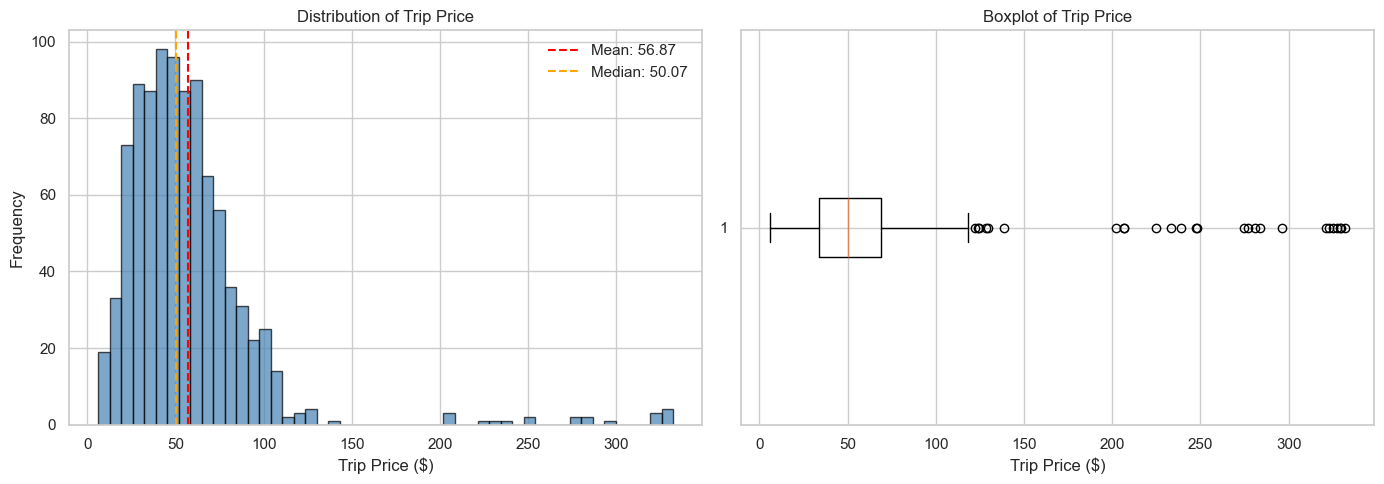

In [99]:
# Phân phối biến target (Trip_Price)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_raw['Trip_Price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_raw['Trip_Price'].mean(), color='red', linestyle='--', label=f"Mean: {df_raw['Trip_Price'].mean():.2f}")
axes[0].axvline(df_raw['Trip_Price'].median(), color='orange', linestyle='--', label=f"Median: {df_raw['Trip_Price'].median():.2f}")
axes[0].set_xlabel('Trip Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Trip Price')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_raw['Trip_Price'].dropna(), vert=False)
axes[1].set_xlabel('Trip Price ($)')
axes[1].set_title('Boxplot of Trip Price')

plt.tight_layout()
plt.show()

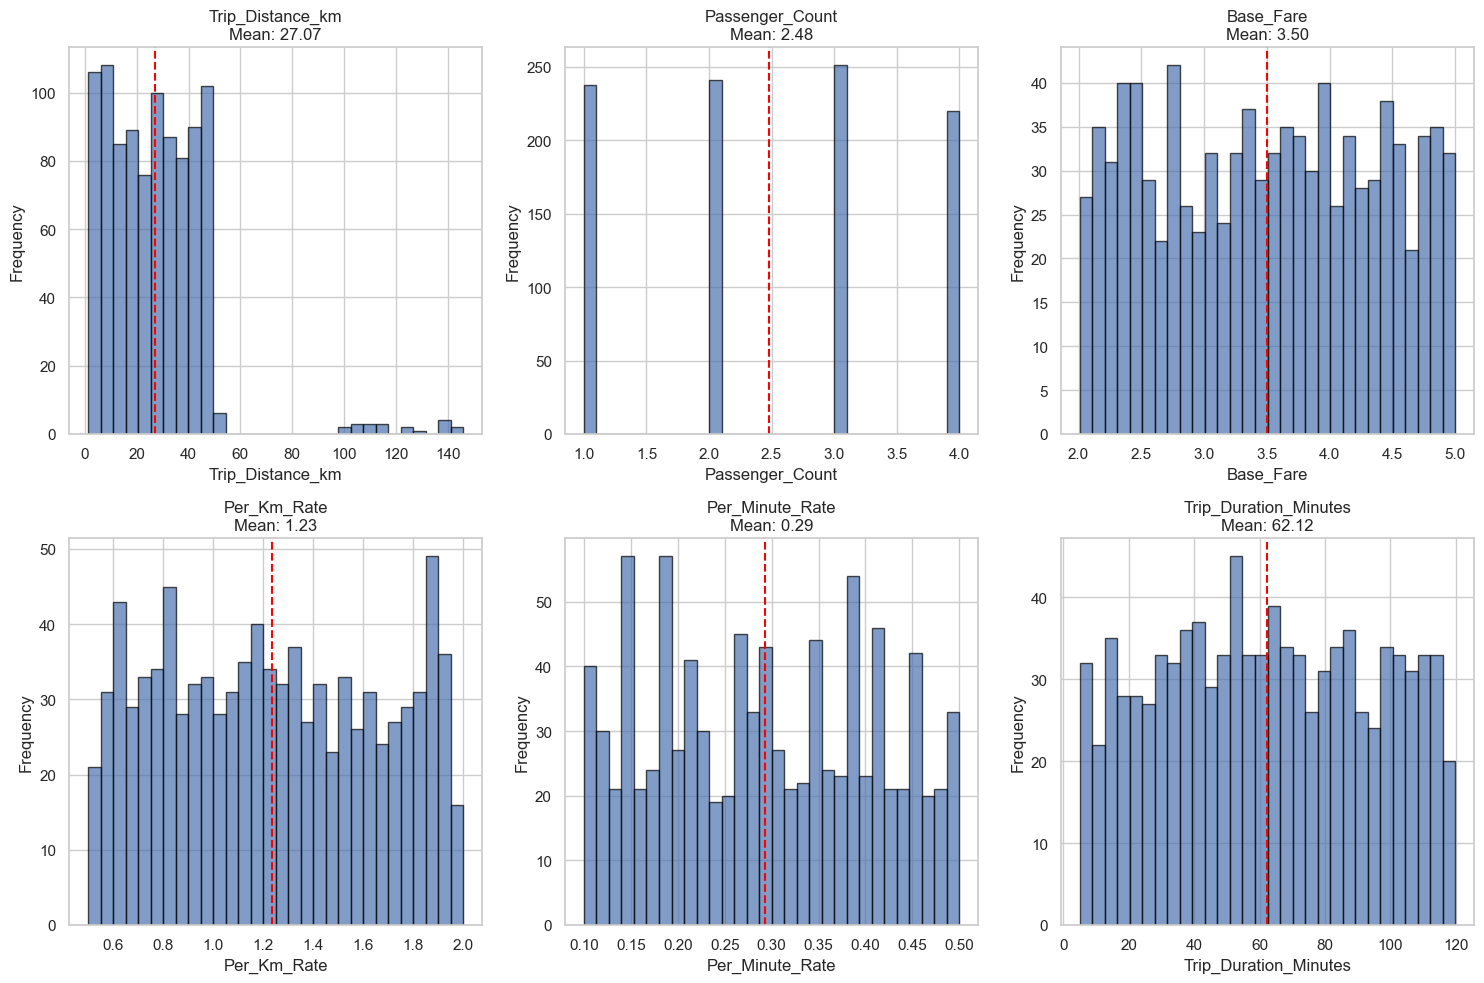

In [100]:
# Phân phối các biến số
numeric_cols = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare', 
                'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(df_raw[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[i].axvline(df_raw[col].mean(), color='red', linestyle='--', linewidth=1.5)
    axes[i].set_title(f'{col}\nMean: {df_raw[col].mean():.2f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

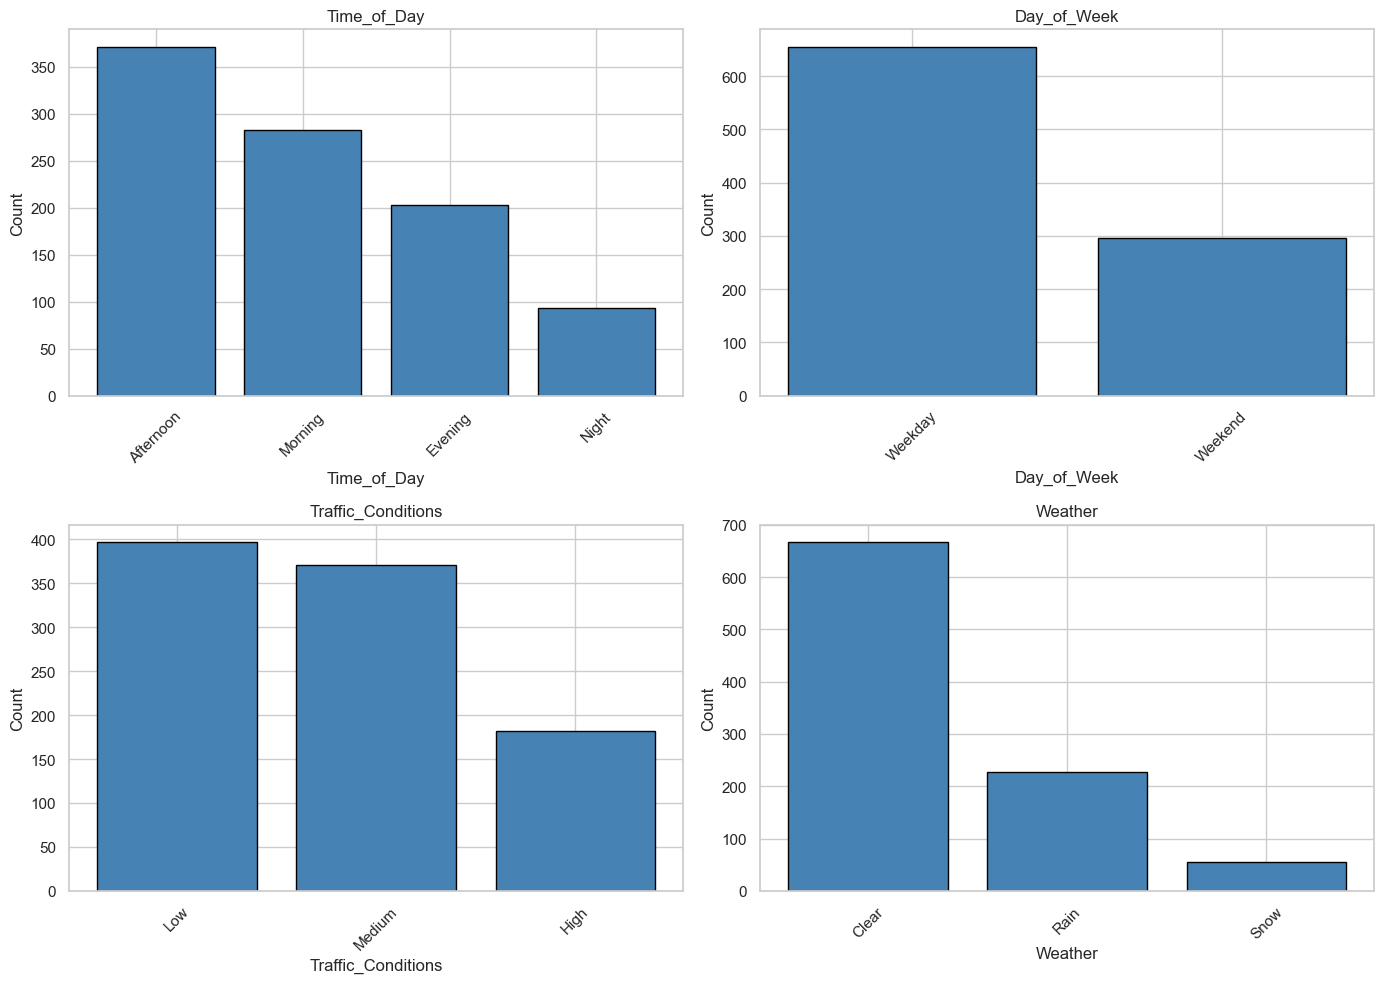

In [101]:
# Biến phân loại
categorical_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    value_counts = df_raw[col].value_counts()
    axes[i].bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

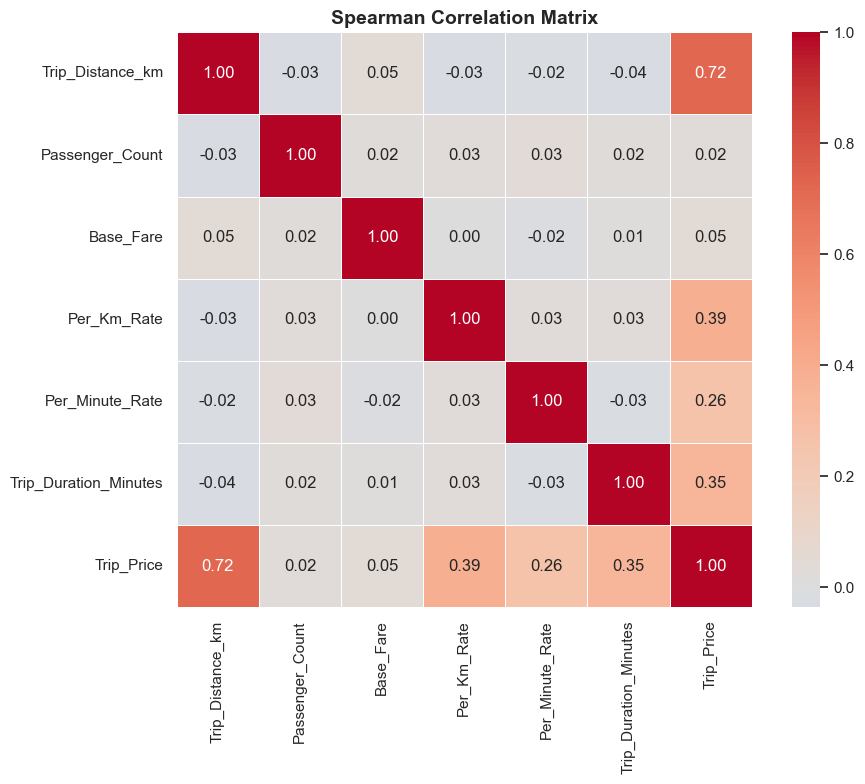

In [102]:
# Correlation Matrix
numeric_df = df_raw.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Spearman Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [103]:
# 3D Scatter Plot với Plotly
color_map = {'Low': 1, 'Medium': 2, 'High': 3}
df_plot = df_raw.copy()
df_plot['Traffic_Num'] = df_plot['Traffic_Conditions'].map(color_map)

fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['Trip_Distance_km'],
    y=df_plot['Trip_Price'],
    z=df_plot['Trip_Duration_Minutes'],
    mode='markers',
    marker=dict(
        size=4,
        color=df_plot['Traffic_Num'],
        colorscale='Viridis',
        opacity=0.7
    )
)])

fig.update_layout(
    title='3D Scatter: Distance vs Price vs Duration',
    scene=dict(
        xaxis_title='Trip Distance (km)',
        yaxis_title='Trip Price ($)',
        zaxis_title='Duration (minutes)'
    ),
    width=800,
    height=600
)
fig.show()

---
## Part 3: Data Preprocessing

**Quy trình tiền xử lý :**

1. **PRE-SPLIT (DataLoader):**
   - Xóa duplicates
   - Unify text values
   - Apply constraints

2. **TRAIN/TEST SPLIT**

3. **POST-SPLIT (DataTransformer):**
   - `fit_transform()` trên TRAIN set
   - `transform_new_data()` trên TEST set

### 3.1 Pre-Split Cleaning (DataLoader)

In [104]:
print("="*70)
print(" PRE-SPLIT CLEANING (DataLoader)")
print("="*70)

# Tạo DataLoader mới từ file
loader = DataLoader.from_file(config.DATA_FILE)
print(f"\n Dữ liệu gốc: {loader.get_data().shape}")

# Bước 1: Xóa duplicates
loader.drop_duplicates()
print(f" Sau drop_duplicates: {loader.get_data().shape}")

# Bước 2: Unify text values (chuẩn hóa chữ hoa/thường)
loader.unify_values()
print(f" Sau unify_values: {loader.get_data().shape}")

# Bước 3: Apply constraints (giới hạn giá trị hợp lệ)
loader.apply_constraints(constraint_rules=config.CONSTRAINT_RULES)
print(f" Sau apply_constraints: {loader.get_data().shape}")

# Lấy dữ liệu đã clean
df_cleaned = loader.get_data()
print(f"\n Final pre-split shape: {df_cleaned.shape}")

 PRE-SPLIT CLEANING (DataLoader)

 Dữ liệu gốc: (1000, 11)
 Sau drop_duplicates: (1000, 11)
 Sau unify_values: (1000, 11)
 Sau apply_constraints: (951, 11)

 Final pre-split shape: (951, 11)


### 3.2 Train/Test Split

In [105]:
print("="*70)
print(" CHIA TRAIN/TEST")
print("="*70)

train_df, test_df = train_test_split(
    df_cleaned,
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_SEED,
    shuffle=True
)

# Reset index
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"\n Train shape: {train_df.shape}")
print(f" Test shape: {test_df.shape}")
print(f" Train ratio: {len(train_df) / len(df_cleaned):.1%}")
print(f" Test ratio: {len(test_df) / len(df_cleaned):.1%}")

 CHIA TRAIN/TEST

 Train shape: (760, 11)
 Test shape: (191, 11)
 Train ratio: 79.9%
 Test ratio: 20.1%


### 3.3 Post-Split Transformation (DataTransformer)

**Quan trọng:**
- `fit_transform()` trên **TRAIN** set → học parameters (mean, scaler, encoder)
- `transform_new_data()` trên **TEST** set → dùng parameters đã học

In [106]:
print("="*70)
print(" POST-SPLIT TRANSFORMATION (DataTransformer)")
print("="*70)

# Khởi tạo DataTransformer với TRAIN data
transformer = DataTransformer(
    data=train_df.copy(),
    missing_strategy=config.MISSING_STRATEGY['numeric'],
    categorical_missing_strategy=config.MISSING_STRATEGY['categorical'],
    scaler_type=config.SCALING_METHOD,
    encoder_type=config.ENCODING_METHOD
)

print(" DataTransformer initialized")

 POST-SPLIT TRANSFORMATION (DataTransformer)
 DataTransformer initialized


In [107]:
# FIT_TRANSFORM trên TRAIN set
print("\n🔧 Fitting và transforming TRAIN set...")

train_processed = transformer.fit_transform(
    target_col=config.TARGET_COLUMN,
    remove_outliers=config.OUTLIER_DETECTION,
    outlier_method=config.OUTLIER_METHOD,
    outlier_threshold=config.OUTLIER_THRESHOLD,
    encoding_method=config.ENCODING_METHOD,
    drop_first_onehot=config.DROP_FIRST_ONEHOT,
    scaling_method=config.SCALING_METHOD,
    interaction_pairs=config.INTERACTION_PAIRS if config.CREATE_INTERACTION_FEATURES else None
)

print(f" Train processed shape: {train_processed.shape}")


🔧 Fitting và transforming TRAIN set...
 Train processed shape: (760, 19)


In [108]:
# TRANSFORM TEST set (dùng parameters đã fit từ train)
print("\n Transforming TEST set...")

test_processed = transformer.transform_new_data(test_df)

print(f" Test processed shape: {test_processed.shape}")


 Transforming TEST set...
 Test processed shape: (191, 19)


In [109]:
# In summary của transformation
transformer.print_summary()

In [110]:
# Chọn features có correlation cao với target cho Polynomial Regression
poly_feature_subset = transformer.get_correlated_features(
    target_col=config.TARGET_COLUMN,
    threshold=config.POLY_CORRELATION_THRESHOLD,
    method='spearman'
)

print(f" Features cho Polynomial (|corr| >= {config.POLY_CORRELATION_THRESHOLD}):")
print(f"   {poly_feature_subset}")

 Features cho Polynomial (|corr| >= 0.3):
   ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']

   ['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes']


In [111]:
# Tách X và y
X_train, y_train = transformer.split_features_target(config.TARGET_COLUMN)
X_test = test_processed.drop(columns=[config.TARGET_COLUMN])
y_test = test_processed[config.TARGET_COLUMN]

print(f"\n FINAL DATA SHAPES:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")


 FINAL DATA SHAPES:
   X_train: (760, 18)
   X_test: (191, 18)
   y_train: (760,)
   y_test: (191,)


In [112]:
# Xem dữ liệu đã xử lý
print("\n📋 X_train processed (first 5 rows):")
X_train.head()


📋 X_train processed (first 5 rows):


,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Time_of_Day_evening,Time_of_Day_morning,Time_of_Day_nan,Time_of_Day_night,Day_of_Week_weekday,Day_of_Week_weekend,Traffic_Conditions_low,Traffic_Conditions_medium,Traffic_Conditions_nan,Weather_nan,Weather_rain,Weather_snow
0,-0.085734,-0.399165,-0.284807,1.563652,0.320067,0.282546,0,1,0,0,0,1,0,1,0,0,0,1
1,0.672897,-0.399165,-0.671939,-0.176885,-0.218695,0.921601,0,0,1,0,0,1,0,1,0,0,1,0
2,-0.068239,1.450624,-0.894833,0.596687,0.679242,-0.592918,0,0,0,1,1,0,1,0,0,0,0,0
3,0.900857,0.525730,1.205063,0.886776,-0.128901,1.634260,0,0,1,0,1,0,1,0,0,0,0,0
4,0.256207,-0.399165,-0.472508,1.660348,-0.308489,0.981795,0,1,0,0,1,0,0,0,0,0,0,0


---
## Part 4: Model Training

**Sử dụng ModelTrainer để huấn luyện 4 mô hình:**
1. Polynomial Regression (với Ridge regularization)
2. Random Forest
3. Extra Trees
4. XGBoost

### 4.1 Khởi tạo ModelTrainer

### 📖 Giải thích các Metrics đánh giá mô hình

| Metric | Công thức | Ý nghĩa | Giá trị tốt |
|--------|-----------|---------|-------------|
| **R² (R-squared)** | $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ | Tỷ lệ phương sai được mô hình giải thích | Gần 1.0 (100%) |
| **RMSE** | $RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$ | Sai số trung bình (phạt nặng lỗi lớn) | Càng nhỏ càng tốt |
| **MAE** | $MAE = \frac{1}{n}\sum_{i=1}^{n}\lvert y_i - \hat{y}_i \rvert$ | Sai số tuyệt đối trung bình | Càng nhỏ càng tốt |

**So sánh RMSE vs MAE:**
- RMSE phạt nặng các lỗi lớn (do bình phương)
- MAE đối xử công bằng với mọi lỗi
- Nếu RMSE >> MAE → có nhiều outliers trong dự đoán

### 🤖 Mô tả các mô hình được sử dụng

| Mô hình | Loại | Đặc điểm | Ưu điểm | Nhược điểm |
|---------|------|----------|---------|------------|
| **Polynomial Regression** | Linear | Mở rộng Linear Regression với các features bậc cao | Đơn giản, dễ hiểu | Dễ overfit với bậc cao |
| **Random Forest** | Ensemble (Bagging) | Tập hợp nhiều Decision Trees | Robust, ít overfit | Chậm với dữ liệu lớn |
| **Extra Trees** | Ensemble (Bagging) | Tương tự RF nhưng random hơn | Nhanh hơn RF, ít overfit hơn | Có thể kém chính xác hơn RF |
| **XGBoost** | Ensemble (Boosting) | Gradient Boosting tối ưu | Hiệu suất cao, xử lý missing | Cần tune nhiều hyperparams |

In [131]:
print("="*70)
print(" KHỞI TẠO MODEL TRAINER")
print("="*70)

trainer = ModelTrainer(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    output_dir=str(config.MODELS_DIR)
)

print(f"\n Data Info:")
for key, value in trainer.data_info.items():
    print(f"   {key}: {value}")

 KHỞI TẠO MODEL TRAINER

 Data Info:
   train_shape: (760, 18)
   test_shape: (191, 18)
   n_features: 18
   n_samples_train: 760
   n_samples_test: 191


### 4.2 Train tất cả models với train_all()

In [132]:
print("="*70)
print(" TRAINING TẤT CẢ MÔ HÌNH")
print("="*70)

# Train với hyperparameters mặc định (không optimize)
# Đặt optimize=True nếu muốn dùng Optuna
trainer.train_all(
    optimize=False,  # True để dùng Optuna optimization
    poly_feature_subset=poly_feature_subset,
    hyperparams=config.DEFAULT_HYPERPARAMS
)

print("\n Hoàn tất training tất cả mô hình!")

 TRAINING TẤT CẢ MÔ HÌNH

 Hoàn tất training tất cả mô hình!

 Hoàn tất training tất cả mô hình!


---
## Part 5: Evaluation & Comparison
### 5.1 Tóm tắt kết quả

In [133]:
# In tóm tắt kết quả
trainer.summary()

        Model Train RMSE Test RMSE Test MAE  Test R²
   POLYNOMIAL  11.197717 13.915598 8.638145 0.917153
RANDOM_FOREST   5.092569 11.950668 6.268112 0.938898
  EXTRA_TREES   1.518646 10.478630 5.715647 0.953024
      XGBOOST   6.549645 16.384479 6.654243 0.885149


In [134]:
# Lấy mô hình tốt nhất
best_name, best_result = trainer.get_best_model()

print("="*70)
print("🏆 MÔ HÌNH TỐT NHẤT")
print("="*70)
print(f"\n   Model: {best_name.upper()}")
print(f"   Test R²: {best_result['test_r2']:.6f}")
print(f"   Test RMSE: {best_result['test_rmse']:.6f}")
print(f"   Test MAE: {best_result['test_mae']:.6f}")
print(f"\n   Hyperparameters: {best_result['hyperparams']}")

🏆 MÔ HÌNH TỐT NHẤT

   Model: EXTRA_TREES
   Test R²: 0.953024
   Test RMSE: 10.478630
   Test MAE: 5.715647

   Hyperparameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1}


### 5.2 So sánh các mô hình

In [117]:
# Tạo DataFrame so sánh
comparison_data = []
for model_name, result in trainer.results.items():
    comparison_data.append({
        'Model': model_name.upper(),
        'Train RMSE': result['train_rmse'],
        'Test RMSE': result['test_rmse'],
        'Test MAE': result['test_mae'],
        'Test R²': result['test_r2'],
        'Overfitting Gap': result['train_rmse'] - result['test_rmse']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test R²', ascending=False)
comparison_df

,Model,Train RMSE,Test RMSE,Test MAE,Test R²,Overfitting Gap
2,EXTRA_TREES,1.518646,10.478630,5.715647,0.953024,-8.959985
1,RANDOM_FOREST,5.092569,11.950668,6.268112,0.938898,-6.858099
0,POLYNOMIAL,11.197717,13.915598,8.638145,0.917153,-2.717881
3,XGBOOST,6.549645,16.384479,6.654243,0.885149,-9.834835


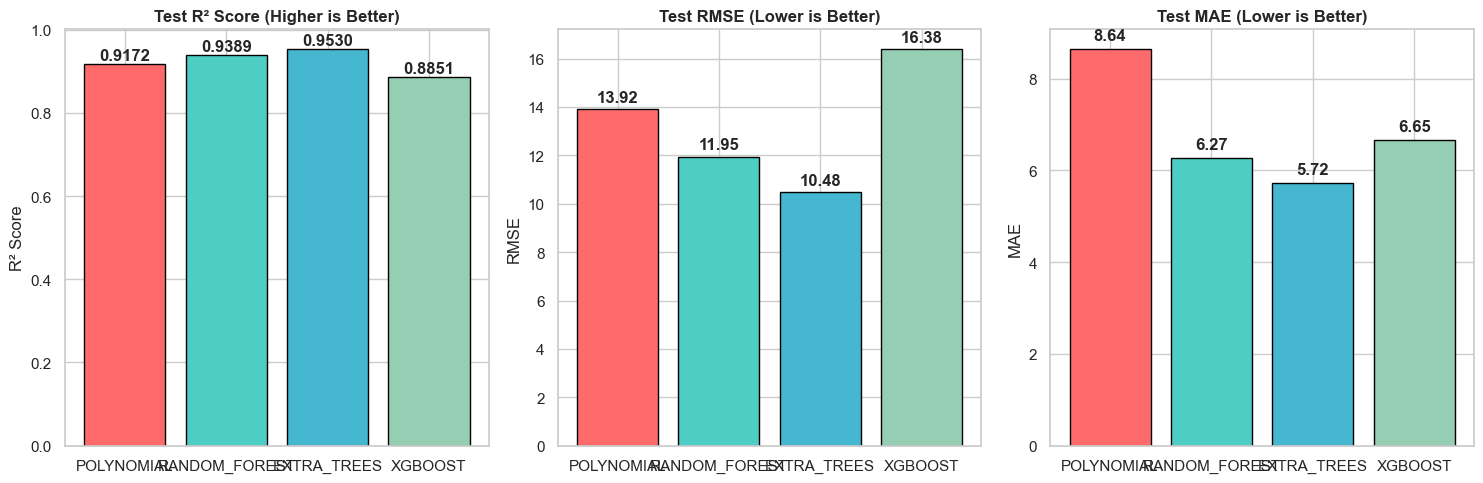

In [118]:
# Vẽ biểu đồ so sánh metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [r['Model'] for r in comparison_data]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# R² Score
r2_scores = [r['Test R²'] for r in comparison_data]
bars = axes[0].bar(models, r2_scores, color=colors, edgecolor='black')
axes[0].set_title('Test R² Score (Higher is Better)', fontweight='bold')
axes[0].set_ylabel('R² Score')
for bar, val in zip(bars, r2_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.4f}', ha='center', fontweight='bold')

# RMSE
rmse_scores = [r['Test RMSE'] for r in comparison_data]
bars = axes[1].bar(models, rmse_scores, color=colors, edgecolor='black')
axes[1].set_title('Test RMSE (Lower is Better)', fontweight='bold')
axes[1].set_ylabel('RMSE')
for bar, val in zip(bars, rmse_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                 f'{val:.2f}', ha='center', fontweight='bold')

# MAE
mae_scores = [r['Test MAE'] for r in comparison_data]
bars = axes[2].bar(models, mae_scores, color=colors, edgecolor='black')
axes[2].set_title('Test MAE (Lower is Better)', fontweight='bold')
axes[2].set_ylabel('MAE')
for bar, val in zip(bars, mae_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 f'{val:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.3 Actual vs Predicted

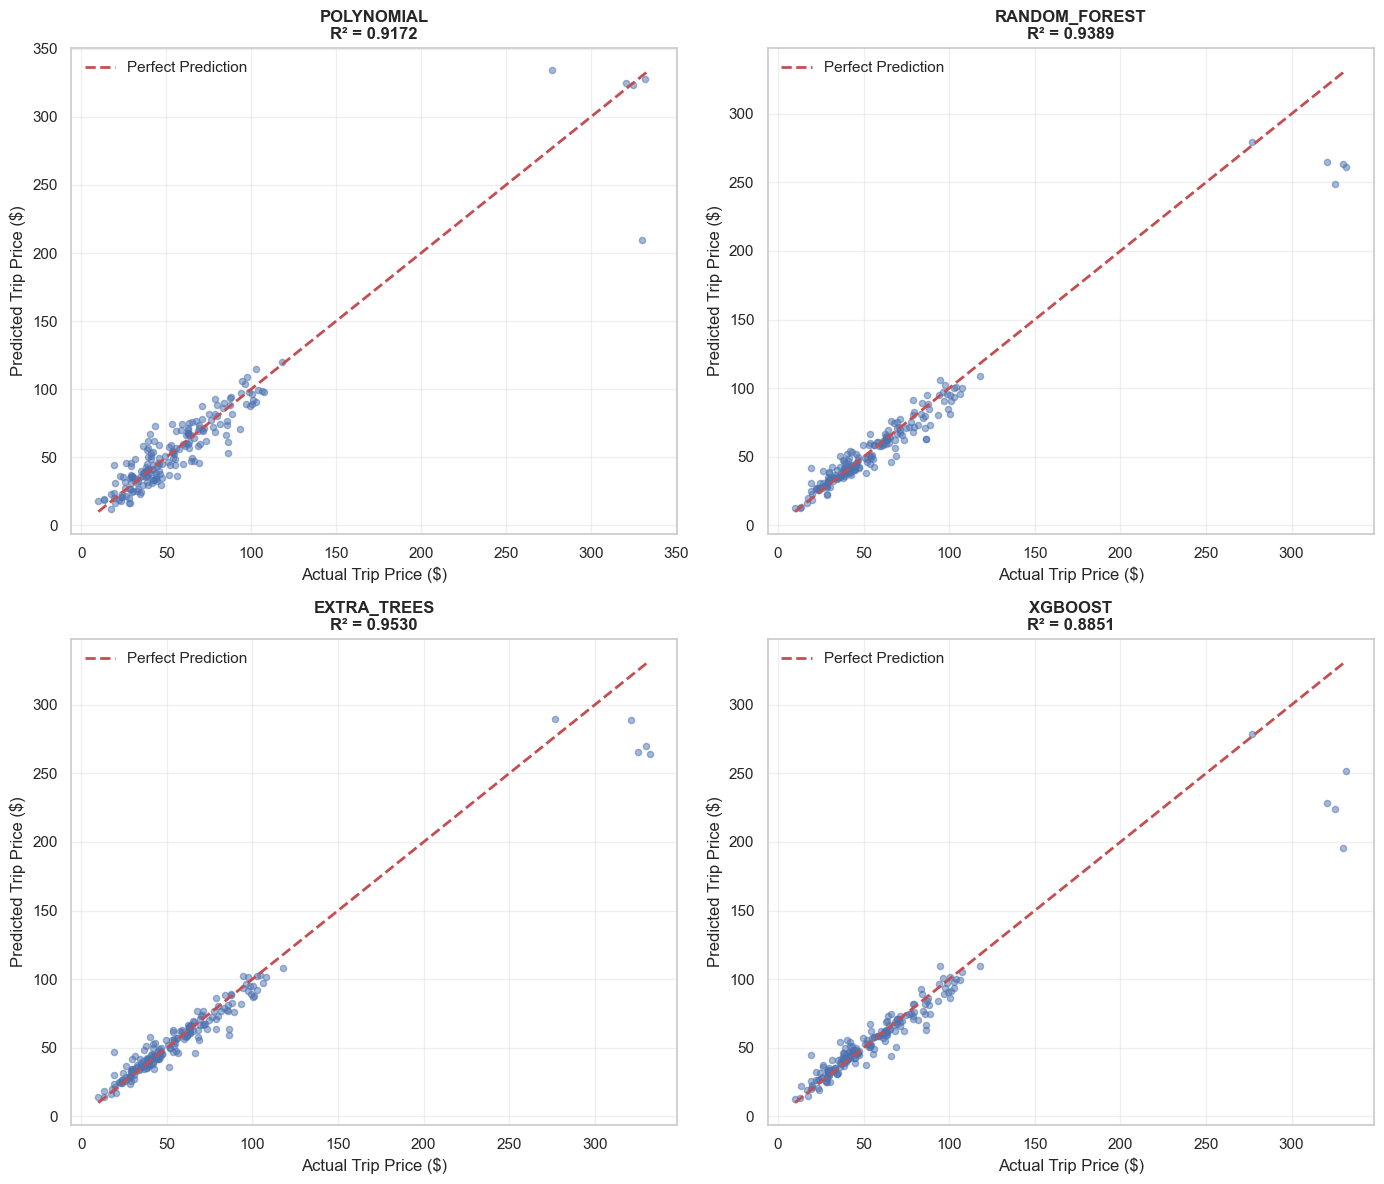

In [119]:
# Vẽ biểu đồ Actual vs Predicted cho tất cả models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

model_names = list(trainer.models.keys())

for idx, model_name in enumerate(model_names):
    model_obj = trainer.models[model_name]['model']
    
    # Xử lý đặc biệt cho Polynomial
    if model_name == 'polynomial':
        X_test_pred = trainer.X_test_transformed.get('polynomial', X_test)
    else:
        X_test_pred = X_test
    
    y_pred = model_obj.predict(X_test_pred)
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Labels
    r2 = trainer.results[model_name]['test_r2']
    axes[idx].set_title(f'{model_name.upper()}\nR² = {r2:.4f}', fontweight='bold')
    axes[idx].set_xlabel('Actual Trip Price ($)')
    axes[idx].set_ylabel('Predicted Trip Price ($)')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.4 Feature Importance

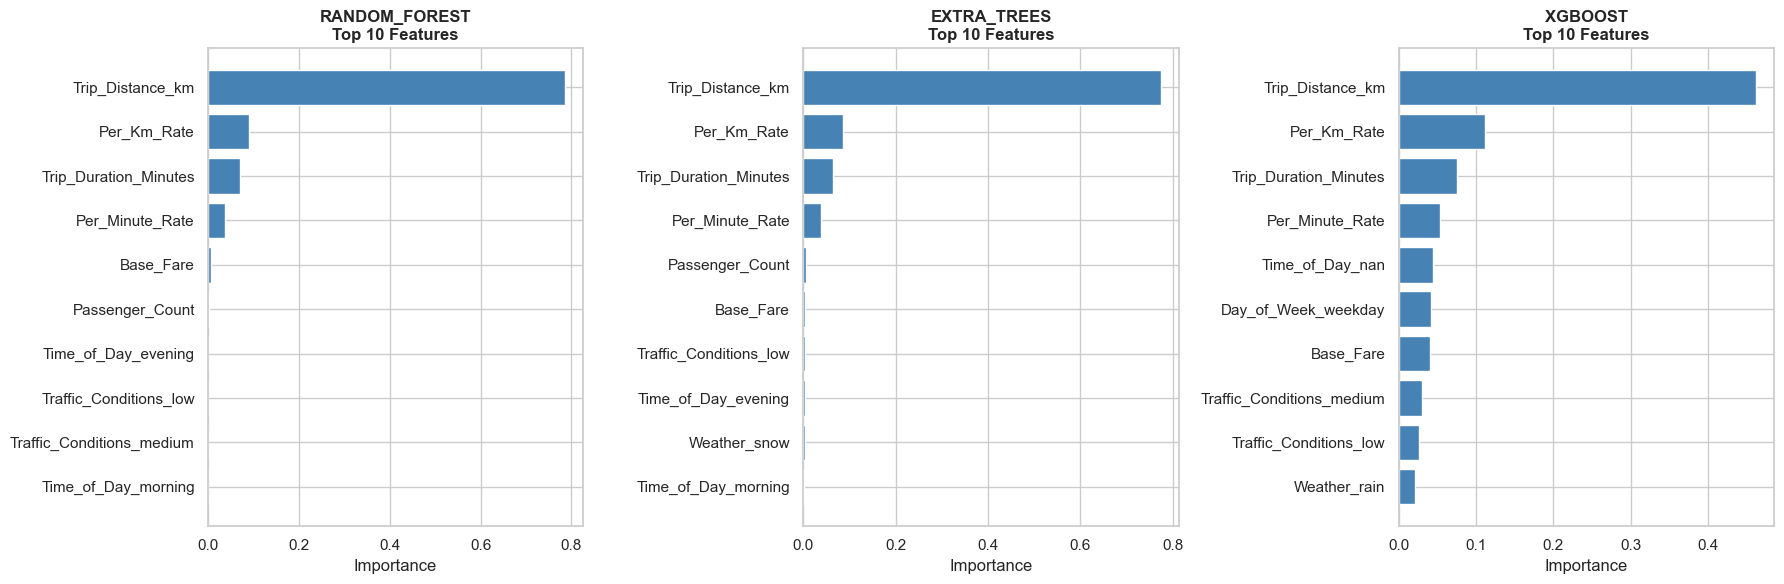

In [120]:
# Feature importance cho tree-based models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

tree_models = ['random_forest', 'extra_trees', 'xgboost']

for idx, model_name in enumerate(tree_models):
    if model_name in trainer.models:
        importance_df = trainer.get_feature_importance(model_name, top_n=10)
        
        if importance_df is not None:
            axes[idx].barh(importance_df['feature'], importance_df['importance'], color='steelblue')
            axes[idx].set_title(f'{model_name.upper()}\nTop 10 Features', fontweight='bold')
            axes[idx].set_xlabel('Importance')
            axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

---
## Part 6: Save & Load Models
### 6.1 Lưu tất cả models

In [136]:
print("="*70)
print(" LƯU MÔ HÌNH VÀ CẤU HÌNH")
print("="*70)

# Lưu tất cả models
saved_paths = trainer.save_all_models(format=config.MODEL_FORMAT)

print(f"\n Đã lưu {len(saved_paths)} mô hình:")
for name, path in saved_paths.items():
    print(f"   {name}: {path}")

 LƯU MÔ HÌNH VÀ CẤU HÌNH

 Đã lưu 4 mô hình:
   polynomial: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\polynomial.joblib
   random_forest: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\random_forest.joblib
   extra_trees: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\extra_trees.joblib
   xgboost: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\xgboost.joblib


In [137]:
# Lưu kết quả đánh giá
trainer.save_results(config.RESULTS_FILE)
print(f"\n Kết quả đã lưu tại: {config.MODEL_RESULTS_DIR / config.RESULTS_FILE}")


 Kết quả đã lưu tại: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\results\model\model_results.json


In [138]:
# Lưu DataTransformer để dùng cho dữ liệu mới
transformer_path = config.MODELS_DIR / "data_transformer.joblib"
transformer.save_state(transformer_path)
print(f"\n DataTransformer đã lưu tại: {transformer_path}")


 DataTransformer đã lưu tại: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\data_transformer.joblib


### 6.2 Load model đã lưu

In [139]:
import glob

# Tìm các file model đã lưu
model_files = glob.glob(str(config.MODELS_DIR / '*.joblib'))

print(f" Các file model trong {config.MODELS_DIR}:")
for f in model_files:
    print(f"   {Path(f).name}")

 Các file model trong d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models:
   data_transformer.joblib
   extra_trees.joblib
   polynomial.joblib
   random_forest.joblib
   xgboost.joblib


In [140]:
# Load model tốt nhất
import joblib

# Tìm file của best model
best_model_file = [f for f in model_files if best_name in f and 'data_' not in f]
if best_model_file:
    best_model_file = best_model_file[-1]  # Lấy file mới nhất
    loaded_model_data = joblib.load(best_model_file)
    loaded_model = loaded_model_data['model']
    
    print(f" Đã load model từ: {best_model_file}")
    print(f"   Type: {type(loaded_model).__name__}")

 Đã load model từ: d:\Nhập môn Python\Đồ án cuối kì\Do_An_Python\models\extra_trees.joblib
   Type: ExtraTreesRegressor


---
## Part 7: Prediction Demo
### 7.1 Dự đoán trên test set

In [141]:
# Dự đoán với best model
if best_name == 'polynomial':
    X_test_pred = trainer.X_test_transformed.get('polynomial', X_test)
else:
    X_test_pred = X_test

y_pred_best = trainer.best_model.predict(X_test_pred)

# Đánh giá
print("="*70)
print(f" KẾT QUẢ DỰ ĐOÁN VỚI {best_name.upper()}")
print("="*70)
print(f"\n   R² Score: {r2_score(y_test, y_pred_best):.6f}")
print(f"   RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.6f}")
print(f"   MAE: {mean_absolute_error(y_test, y_pred_best):.6f}")

 KẾT QUẢ DỰ ĐOÁN VỚI EXTRA_TREES

   R² Score: 0.953024
   RMSE: 10.478630
   MAE: 5.715647


In [142]:
# So sánh một số mẫu cụ thể
print("\n SO SÁNH MỘT SỐ MẪU CỤ THỂ:")
print("="*70)

sample_indices = [0, 10, 20, 30, 40]

sample_data = []
for idx in sample_indices:
    actual = y_test.iloc[idx]
    predicted = y_pred_best[idx]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100 if actual != 0 else 0
    
    sample_data.append({
        'Sample': idx,
        'Actual ($)': f"{actual:.2f}",
        'Predicted ($)': f"{predicted:.2f}",
        'Error ($)': f"{error:.2f}",
        'Error (%)': f"{error_pct:.1f}%"
    })

sample_df = pd.DataFrame(sample_data)
print(sample_df.to_string(index=False))


 SO SÁNH MỘT SỐ MẪU CỤ THỂ:
 Sample Actual ($) Predicted ($) Error ($) Error (%)
      0      31.38         43.66     12.28     39.1%
     10      43.97         42.34      1.64      3.7%
     20      36.03         36.67      0.64      1.8%
     30      66.04         68.87      2.83      4.3%
     40      85.88         76.68      9.20     10.7%


### 7.2 Dự đoán với dữ liệu mới (Demo)

In [143]:
# Demo: Tạo dữ liệu mới để dự đoán
# (Trong thực tế, dữ liệu này sẽ đến từ nguồn khác)

new_data = pd.DataFrame({
    'Trip_Distance_km': [5.0, 10.0, 15.0],
    'Passenger_Count': [2, 3, 4],
    'Base_Fare': [3.0, 3.0, 3.0],
    'Per_Km_Rate': [1.5, 1.5, 1.5],
    'Per_Minute_Rate': [0.5, 0.5, 0.5],
    'Trip_Duration_Minutes': [15, 25, 35],
    'Time_of_Day': ['Morning', 'Afternoon', 'Evening'],
    'Day_of_Week': ['Monday', 'Wednesday', 'Friday'],
    'Traffic_Conditions': ['Low', 'Medium', 'High'],
    'Weather': ['Clear', 'Rainy', 'Clear']
})

print("📋 Dữ liệu mới cần dự đoán:")
new_data

📋 Dữ liệu mới cần dự đoán:


,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Time_of_Day,Day_of_Week,Traffic_Conditions,Weather
0,5.0,2,3.0,1.5,0.5,15,Morning,Monday,Low,Clear
1,10.0,3,3.0,1.5,0.5,25,Afternoon,Wednesday,Medium,Rainy
2,15.0,4,3.0,1.5,0.5,35,Evening,Friday,High,Clear


In [146]:
# Transform dữ liệu mới bằng transformer đã fit
new_data_processed = transformer.transform_new_data(new_data)

# Bỏ cột target nếu có (trường hợp này không có)
if config.TARGET_COLUMN in new_data_processed.columns:
    new_data_processed = new_data_processed.drop(columns=[config.TARGET_COLUMN])

print(f" Dữ liệu sau transform: {new_data_processed.shape}")

 Dữ liệu sau transform: (3, 18)


In [148]:
# Dự đoán
# Lưu ý: Nếu best model là polynomial, cần transform thêm
if best_name == 'polynomial':
    poly = trainer.models['polynomial']['poly']
    feature_subset = trainer.models['polynomial'].get('feature_subset')
    
    if feature_subset:
        new_data_pred = new_data_processed[feature_subset]
    else:
        new_data_pred = new_data_processed
    
    new_data_pred = poly.transform(new_data_pred)
else:
    new_data_pred = new_data_processed

predictions = trainer.best_model.predict(new_data_pred)

print("="*70)
print(" KẾT QUẢ DỰ ĐOÁN GIÁ TAXI")
print("="*70)

for i, pred in enumerate(predictions):
    print(f"\n   Trip {i+1}:")
    print(f"   - Distance: {new_data.iloc[i]['Trip_Distance_km']} km")
    print(f"   - Duration: {new_data.iloc[i]['Trip_Duration_Minutes']} min")
    print(f"   - Traffic: {new_data.iloc[i]['Traffic_Conditions']}")
    print(f"   -  Predicted Price: ${pred:.2f}")

 KẾT QUẢ DỰ ĐOÁN GIÁ TAXI

   Trip 1:
   - Distance: 5.0 km
   - Duration: 15 min
   - Traffic: Low
   -  Predicted Price: $14.84

   Trip 2:
   - Distance: 10.0 km
   - Duration: 25 min
   - Traffic: Medium
   -  Predicted Price: $28.51

   Trip 3:
   - Distance: 15.0 km
   - Duration: 35 min
   - Traffic: High
   -  Predicted Price: $42.44


---
## 📝 Tổng kết

### 🏆 Kết quả đạt được:

| Model | Test R² | Test RMSE | Test MAE | Đánh giá |
|-------|---------|-----------|----------|----------|
| **EXTRA_TREES** | **0.9530** ⭐ | **10.48** | **5.72** | **Tốt nhất** |
| RANDOM_FOREST | 0.9389 | 11.95 | 6.27 | Tốt |
| POLYNOMIAL | 0.9172 | 13.92 | 8.64 | Khá |
| XGBOOST | 0.8851 | 16.38 | 6.65 | Trung bình |

### 📊 Insights từ Feature Importance:
1. **Trip_Distance_km** là feature quan trọng nhất (~70-80% importance)
2. **Per_Km_Rate** đứng thứ 2 (~10-15%)
3. **Trip_Duration_Minutes** và **Per_Minute_Rate** cũng đóng góp đáng kể

### 📁 Các files đã lưu:
- **Models**: `models/*.joblib`
- **Transformer**: `models/data_transformer.joblib`
- **Results**: `results/model/model_results.json`

### 💡 Cách sử dụng model để predict:
```python
import joblib
from src.preprocessing import DataTransformer

# Load transformer và model
transformer = DataTransformer.load_state('models/data_transformer.joblib')
model_data = joblib.load('models/extra_trees.joblib')
model = model_data['model']

# Transform và predict
new_data_processed = transformer.transform_new_data(new_data)
predictions = model.predict(new_data_processed)
```

### 🔍 Nhận xét:
- **Extra Trees** cho kết quả tốt nhất với R² = 0.953
- Mô hình giải thích được ~95% phương sai trong dữ liệu
- Sai số trung bình (MAE) khoảng $5.72 - chấp nhận được cho dự đoán giá taxi